# Exploring UniRep representations of PETase data

In [1]:
!pip install git+https://github.com/ElArkk/jax-unirep.git --upgrade
!pip install optuna
!pip install biopython

  Cloning https://github.com/ElArkk/jax-unirep.git to /tmp/pip-req-build-z1275ie8
  Running command git clone -q https://github.com/ElArkk/jax-unirep.git /tmp/pip-req-build-z1275ie8
  Created wheel for jax-unirep: filename=jax_unirep-0.1-cp36-none-any.whl size=135455665 sha256=0761ebab10910f2fc3520257d92a571c80007ee5d80632d95a007cbbcd46fa82
  Stored in directory: /tmp/pip-ephem-wheel-cache-t_ncjeya/wheels/08/4d/ac/6e75862c118d1ad82122f410859524b20190ce7a821b76ffcd
Successfully built jax-unirep
     |████████████████████████████████| 163kB 2.7MB/s 
     |████████████████████████████████| 1.1MB 8.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 7.4MB/s 
     |████████████████████████████████| 81kB 9.2MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 112kB 15.

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
gdrive_path = "/content/drive/My Drive/Colab Notebooks/UniRep/"
!ls "/content/drive/My Drive/Colab Notebooks/UniRep"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
BLAC_data_exploration.ipynb		PETase_data_exploration.ipynb
blac_fitness.txt			PETase_mutant_fitness.txt
blac_seqs.txt				PETase_mutant_seqs.txt
blac_unirep_global_init_1		PETase_weights_1E5_epoch4
blac_unirep_global_init_1.zip		seqs.txt
blac_unirep_random_init_1.zip		temp
data_utils.py				train_set.fasta.txt
formatted.txt				train_set_formatted.fasta.txt
get_reps.ipynb				train_top.ipynb
in_domain_val_set.fasta.txt		unirep.py
in_domain_val_set_formatted.fasta

In [3]:
from jax_unirep import get_reps, fit
from jax_unirep.utils import load_params_1900
from Bio import SeqIO
import pandas as pd
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



### Load sequences

In [0]:
# read FASTA file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_fasta(name):
    fasta_seqs = SeqIO.parse(open(gdrive_path + name + '.fasta.txt'),'fasta')
    data = []
    for fasta in fasta_seqs:
        data.append([fasta.id, str(fasta.seq).strip()])
    
    return data

In [0]:
# read sequence text file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_labeled_data(name):
    seqs = np.loadtxt(gdrive_path + name + '_seqs.txt', dtype='str')
    fitnesses = np.loadtxt(gdrive_path + name + '_fitness.txt', dtype='float')
    data = []
    for seq, fitness in zip(seqs, fitnesses):
        data.append([str(seq).strip(), fitness])
    
    return data

In [0]:
# Load PETase evotuning data (unlabeled)
train_df = pd.DataFrame(read_fasta('train_set'), columns = ['name', 'sequence'])
out_val_df = pd.DataFrame(read_fasta('out_domain_val_set'), columns = ['name', 'sequence'])


In [7]:
# load labeled PETase top model training data
PETase_df = pd.DataFrame(read_labeled_data('PETase_mutant'), columns = ['sequence', 'fitness'])
PETase_df.head()

,sequence,fitness
0,MNFPRASRLMQAAVLGGLMAVSAAATAQTNPYARGPNPTAASLEAS...,0.0
1,MNFPRASRLMQAAVLGGLMAVSAAATAQTNPYARGPNPTAASLEAS...,1.5
2,MNFPRASRLMQAAVLGGLMAVSAAATAQTNPYARGPNPTAASLEAS...,-5.0
3,MNFPRASRLMQAAVLGGLMAVSAAATAQTNPYARGPNPTAASLEAS...,-6.0
4,MNFPRASRLMQAAVLGGLMAVSAAATAQTNPYARGPNPTAASLEAS...,-1.0


## Get Reps


In [0]:
# load params for PETase evotuned weights

PETase_params = load_params_1900(gdrive_path + 'PETase_weights_1E5_epoch4')

# load params for BLAC evotuned weights

blac_params = load_params_1900(gdrive_path + 'blac_unirep_global_init_1')

In [35]:
# GET reps for LABELED DATA:

N_seqs = len(PETase_df)
print(N_seqs)

# vary batches based on memory available
# this google colab can handle around 1000 seqs per batch for sure
N_BATCHES = 1

BATCH_LEN = int(np.ceil(N_seqs/N_BATCHES))

# for unirep

# get 1st sequence representation
unirep, _, _ = get_reps(PETase_df.sequence[0])

feat_cols = [ 'feat' + str(j) for j in range(1, unirep.shape[1] + 1) ]
unirep_df = pd.DataFrame(unirep, columns=feat_cols)
unirep_df.insert(0, "sequence", PETase_df.sequence[0])
unirep_df.insert(1, "fitness", PETase_df.fitness[0])

# get the rest of the sequences and append to df
for i in range(N_BATCHES):
  this_unirep, _, _ = get_reps(PETase_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ] )
  this_unirep_df = pd.DataFrame(this_unirep, columns=feat_cols)
  this_unirep_df.insert(0, "sequence", PETase_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
  this_unirep_df.insert(1, "fitness", PETase_df.fitness[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
  unirep_df = pd.concat([unirep_df.reset_index(drop=True), this_unirep_df.reset_index(drop=True)]).reset_index(drop=True)

unirep_df.head()

# do the same for eunirep

# get 1st sequence representation
eunirep, _, _ = get_reps(PETase_df.sequence[0], params=PETase_params)

efeat_cols = [ 'feat' + str(j) for j in range(1, eunirep.shape[1] + 1) ]
eunirep_df = pd.DataFrame(eunirep, columns=efeat_cols)
eunirep_df.insert(0, "sequence", PETase_df.sequence[0])
eunirep_df.insert(1, "fitness", PETase_df.fitness[0])

# get the rest of the sequences and append to df
for i in range(N_BATCHES):
  this_eunirep, _, _ = get_reps(PETase_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ], params=PETase_params)
  this_eunirep_df = pd.DataFrame(this_eunirep, columns=efeat_cols)
  this_eunirep_df.insert(0, "sequence", PETase_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
  this_eunirep_df.insert(1, "fitness", PETase_df.fitness[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
  eunirep_df = pd.concat([eunirep_df.reset_index(drop=True), this_eunirep_df.reset_index(drop=True)]).reset_index(drop=True)

eunirep_df.head()

# do the same for blac_eunirep

# get 1st sequence representation
eunirep2, _, _ = get_reps(PETase_df.sequence[0], params=blac_params)

efeat_cols = [ 'feat' + str(j) for j in range(1, eunirep2.shape[1] + 1) ]
eunirep2_df = pd.DataFrame(eunirep2, columns=efeat_cols)
eunirep2_df.insert(0, "sequence", PETase_df.sequence[0])
eunirep2_df.insert(1, "fitness", PETase_df.fitness[0])

# get the rest of the sequences and append to df
for i in range(N_BATCHES):
  this_eunirep, _, _ = get_reps(PETase_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ], params=blac_params)
  this_eunirep_df = pd.DataFrame(this_eunirep, columns=efeat_cols)
  this_eunirep_df.insert(0, "sequence", PETase_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
  this_eunirep_df.insert(1, "fitness", PETase_df.fitness[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
  eunirep2_df = pd.concat([eunirep2_df.reset_index(drop=True), this_eunirep_df.reset_index(drop=True)]).reset_index(drop=True)

eunirep2_df.head()

85


,sequence,fitness,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29,feat30,feat31,feat32,feat33,feat34,feat35,feat36,feat37,feat38,...,feat1861,feat1862,feat1863,feat1864,feat1865,feat1866,feat1867,feat1868,feat1869,feat1870,feat1871,feat1872,feat1873,feat1874,feat1875,feat1876,feat1877,feat1878,feat1879,feat1880,feat1881,feat1882,feat1883,feat1884,feat1885,feat1886,feat1887,feat1888,feat1889,feat1890,feat1891,feat1892,feat1893,feat1894,feat1895,feat1896,feat1897,feat1898,feat1899,feat1900
0,MNFPRASRLMQAAVLGGLMAVSAAATAQTNPYARGPNPTAASLEAS...,0.0,0.030554,0.113849,0.192914,-0.112609,-0.179521,0.038046,-0.164723,-0.075454,-0.033853,0.089434,-0.061011,-0.009972,0.110987,-0.047070,0.005435,0.007244,0.035721,-0.098449,0.480868,-0.043615,-0.020785,0.001162,0.126271,-0.085427,-0.088214,-0.190430,-0.087138,0.012015,-0.177234,0.025064,-0.229405,-0.285523,0.048857,0.040872,-0.120749,-0.097245,0.015968,0.045495,...,-0.136710,0.098586,-0.174091,0.216957,-0.243827,-0.176919,0.004396,-0.511624,-0.005662,-0.367717,0.243668,0.126883,0.090188,0.049831,-0.027476,-0.007013,-0.055476,0.031370,0.235969,0.244262,0.098168,-0.073400,0.131558,-0.011564,-0.010569,0.156254,-0.188152,0.174603,-0.068325,0.021888,0.139460,0.050207,-0.199841,-0.022986,-0.194739,-0.099018,0.201294,-0.071429,-0.114733,-0.062309
1,MNFPRASRLMQAAVLGGLMAVSAAATAQTNPYARGPNPTAASLEAS...,1.5,0.024619,0.103034,0.156049,-0.102027,-0.137607,0.026482,-0.226832,-0.072303,-0.024738,0.110208,-0.057532,-0.008524,0.079283,-0.026538,0.004166,0.006925,0.032731,-0.094798,0.544204,-0.039707,-0.017910,-0.002775,0.137213,-0.123714,-0.099369,-0.200384,-0.069640,0.006852,-0.190980,0.008559,-0.193820,-0.320654,0.046985,0.086622,-0.124939,-0.088488,0.012928,0.043874,...,-0.122848,0.093857,-0.124664,0.239760,-0.280020,-0.195904,0.004449,-0.596480,-0.005576,-0.328916,0.229766,0.161599,0.082101,0.062039,0.041460,-0.014058,-0.059078,0.020630,0.233236,0.231478,0.113376,-0.039439,0.147031,-0.007136,-0.009894,0.155326,-0.201083,0.177286,-0.063421,0.018565,0.112944,0.048860,-0.160958,-0.006753,-0.198477,-0.132603,0.225158,-0.077330,-0.086906,-0.075683
2,MNFPRASRLMQAAVLGGLMAVSAAATAQTNPYARGPNPTAASLEAS...,-5.0,0.026136,0.096386,0.167309,-0.083645,-0.128240,0.016635,-0.245956,-0.072372,-0.027377,0.113259,-0.054588,-0.008831,0.074893,-0.018963,0.003742,0.007577,0.032705,-0.101016,0.538119,-0.041862,-0.017895,-0.009083,0.142932,-0.139727,-0.100719,-0.205423,-0.061861,0.006268,-0.178079,-0.003458,-0.214995,-0.343349,0.047829,0.103867,-0.119214,-0.097724,0.013448,0.048106,...,-0.127538,0.097949,-0.109406,0.271804,-0.286898,-0.195827,0.004449,-0.598240,-0.006107,-0.313258,0.217598,0.176236,0.084103,0.067061,0.085230,-0.025968,-0.053651,0.019690,0.249352,0.205979,0.123090,-0.037017,0.158360,-0.008077,-0.010198,0.161186,-0.192024,0.199869,-0.068393,0.019736,0.113640,0.050638,-0.124015,0.003327,-0.208821,-0.134631,0.230009,-0.083650,-0.044502,-0.078006
3,MNFPRASRLMQAAVLGGLMAVSAAATAQTNPYARGPNPTAASLEAS...,-6.0,0.026071,0.096412,0.160940,-0.081232,-0.126507,0.018019,-0.245610,-0.072670,-0.026995,0.113115,-0.054964,-0.008247,0.077289,-0.018506,0.003788,0.007698,0.032714,-0.100974,0.537447,-0.042219,-0.017754,-0.009060,0.142696,-0.136351,-0.102195,-0.202842,-0.061741,0.005682,-0.175997,-0.003983,-0.216633,-0.342701,0.047902,0.100974,-0.118899,-0.098097,0.013891,0.049469,...,-0.130984,0.097900,-0.108198,0.277056,-0.284179,-0.195590,0.004454,-0.596536,-0.005865,-0.316505,0.218465,0.174694,0.084154,0.069877,0.081346,-0.024450,-0.054045,0.019728,0.250525,0.204401,0.124013,-0.033934,0.161125,-0.008420,-0.010559,0.161743,-0.188528,0.192138,-0.069933,0.019513,0.115770,0.052432,-0.121897,0.009424,-0.204807,-0.137104,0.229616,-0.090281,-0.053475,-0.078195
4,MNFPRASRLMQAAVLGGLMAVSAAATAQTNPYARGPNPTAASLEAS...,-1.0,0.024608,0.095957,0.157759,-0.078210,-0.136343,0.006780,-0.266855,-0.072949,-0.027120,

In [0]:
# CAN'T RUN RIGHT NOW DUE TO MEMORY CONSTRAINTS!!
# get random subset of 6k of ~70k training dataset of proteins similar to PETase
N_seqs = 6000

np.random.seed(42)
rndperm = np.random.permutation(train_df.shape[0])
PETaseish_df = train_df.loc[rndperm[:N_seqs]].reset_index(drop=True)

# vary batches based on memory available
# right now its trial and error to see what doesn't crash
N_BATCHES = 30

BATCH_LEN = int(np.ceil(N_seqs/N_BATCHES))

# get 1st sequence representation
PETaseish_unirep, _, _ = get_reps(PETaseish_df.sequence[0])

feat_cols = [ 'feat' + str(j) for j in range(1, PETaseish_unirep.shape[1] + 1) ]
PETaseish_unirep_df = pd.DataFrame(PETaseish_unirep, columns=feat_cols)
PETaseish_unirep_df.insert(0, "sequence", PETaseish_df.sequence[0])

# get the rest of the sequences and append to df
for i in range(N_BATCHES):
  this_unirep, _, _ = get_reps( list(PETaseish_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ]) )
  this_unirep_df = pd.DataFrame(this_unirep, columns=feat_cols)
  this_unirep_df.insert(0, "sequence", PETaseish_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
  PETaseish_unirep = pd.concat([PETaseish_unirep_df.reset_index(drop=True), this_unirep_df.reset_index(drop=True)]).reset_index(drop=True)

PETaseish_unirep_df.head()


RuntimeError: ignored

In [0]:
# CAN'T RUN RIGHT NOW DUE TO MEMORY CONSTRAINTS!!
# do the same for eunirep

# get 1st sequence representation
PETaseish_eunirep, _, _ = get_reps(PETaseish_df.sequence[0], params=PETase_params)

PETaseish_eunirep_df = pd.DataFrame(PETaseish_eunirep, columns=feat_cols)
PETaseish_eunirep_df.insert(0, "sequence", PETaseish_df.sequence[0])

# get the rest of the sequences and append to df
for i in range(N_BATCHES):
  this_unirep, _, _ = get_reps(list(PETaseish_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ]), params=PETase_params)
  this_unirep_df = pd.DataFrame(this_unirep, columns=feat_cols)
  this_unirep_df.insert(0, "sequence", PETaseish_df.sequence[ (1 + i*BATCH_LEN) : min( 1 + (i+1)*BATCH_LEN, N_seqs ) ].reset_index(drop=True))
  PETaseish_unirep = pd.concat([PETaseish_eunirep_df.reset_index(drop=True), this_unirep_df.reset_index(drop=True)]).reset_index(drop=True)

PETaseish_eunirep_df.head()

## Data Exploration

In [36]:
# 3 component PCA on unirep representations:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(unirep_df[feat_cols].values)
unirep_df['pca1'] = pca_result[:,0]
unirep_df['pca2'] = pca_result[:,1] 
unirep_df['pca3'] = pca_result[:,2]
print('UniRep: Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# same thing on eunirep:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(eunirep_df[efeat_cols].values)
eunirep_df['pca1'] = pca_result[:,0]
eunirep_df['pca2'] = pca_result[:,1] 
eunirep_df['pca3'] = pca_result[:,2]
print('eUniRep: Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# same thing on eunirep2:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(eunirep_df[efeat_cols].values)
eunirep2_df['pca1'] = pca_result[:,0]
eunirep2_df['pca2'] = pca_result[:,1] 
eunirep2_df['pca3'] = pca_result[:,2]
print('eUniRep2: Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

UniRep: Explained variation per principal component: [0.3818674  0.15833358 0.11410079]
eUniRep: Explained variation per principal component: [0.35521722 0.15899757 0.13046023]
eUniRep2: Explained variation per principal component: [0.35521737 0.15899779 0.1304602 ]


<Figure size 432x288 with 0 Axes>

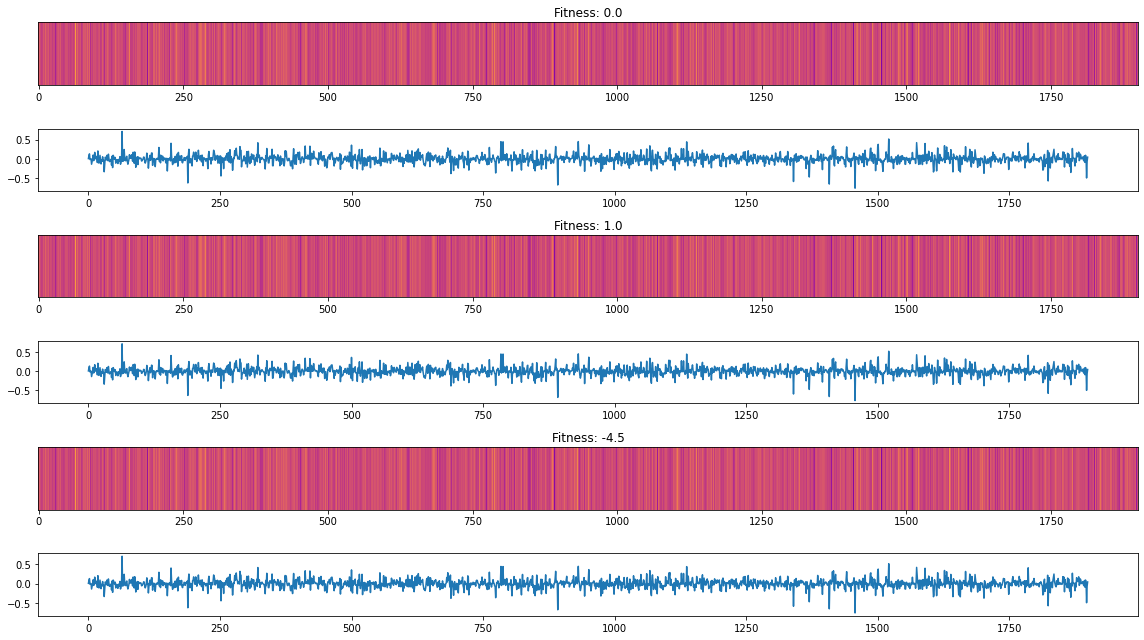

In [37]:
# visualize full representation of each sequence by feature value
# we don't expect to get anything out of these plots
INDCES_TO_SHOW = [0,22,79]

plt.clf()
fig = plt.figure(figsize=(16,3*len(INDCES_TO_SHOW)))
x = np.arange(len(feat_cols))
extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]

for i in range(len(INDCES_TO_SHOW)):
  y = unirep_df.loc[INDCES_TO_SHOW[i], feat_cols].values.astype(float)

  ax = fig.add_subplot(len(INDCES_TO_SHOW)*2,1,(i*2+1), title="Fitness: " + str(unirep_df.loc[INDCES_TO_SHOW[i],'fitness']))
  ax.imshow(y[np.newaxis,:], cmap="plasma", aspect="auto", extent=extent)
  ax.set_yticks([])
  ax.set_xlim(extent[0], extent[1])

  ax2 = fig.add_subplot(len(INDCES_TO_SHOW)*2,1,i*2+2)
  ax2.plot(x,y)

plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

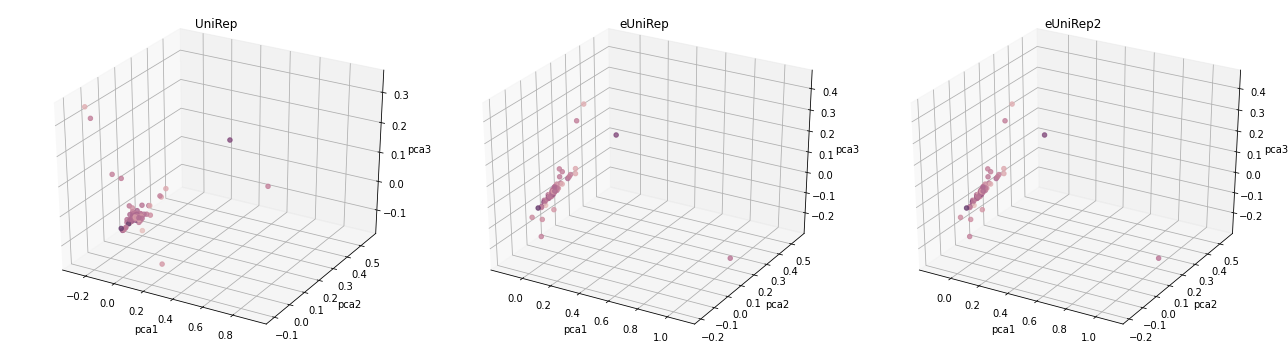

In [39]:
# 3D Plot of first 3 PC's

plt.clf()
fig = plt.figure( figsize=(18,5) )

ax = fig.add_subplot(1,3,1, title="UniRep", projection="3d")
ax.scatter(
    xs=unirep_df["pca1"], 
    ys=unirep_df["pca2"], 
    zs=unirep_df["pca3"], 
    c=unirep_df["fitness"], 
    cmap=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    alpha=0.8
)
ax.set_xlabel('pca1')
ax.set_ylabel('pca2')
ax.set_zlabel('pca3')

ax2 = fig.add_subplot(1,3,2, title="eUniRep", projection="3d")
ax2.scatter(
    xs=eunirep_df["pca1"], 
    ys=eunirep_df["pca2"], 
    zs=eunirep_df["pca3"], 
    c=eunirep_df["fitness"], 
    cmap=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    alpha=0.8
)
ax2.set_xlabel('pca1')
ax2.set_ylabel('pca2')
ax2.set_zlabel('pca3')

ax3 = fig.add_subplot(1,3,3, title="eUniRep2", projection="3d")
ax3.scatter(
    xs=eunirep2_df["pca1"], 
    ys=eunirep2_df["pca2"], 
    zs=eunirep2_df["pca3"], 
    c=eunirep2_df["fitness"], 
    cmap=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    alpha=0.8
)
ax3.set_xlabel('pca1')
ax3.set_ylabel('pca2')
ax3.set_zlabel('pca3')


plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

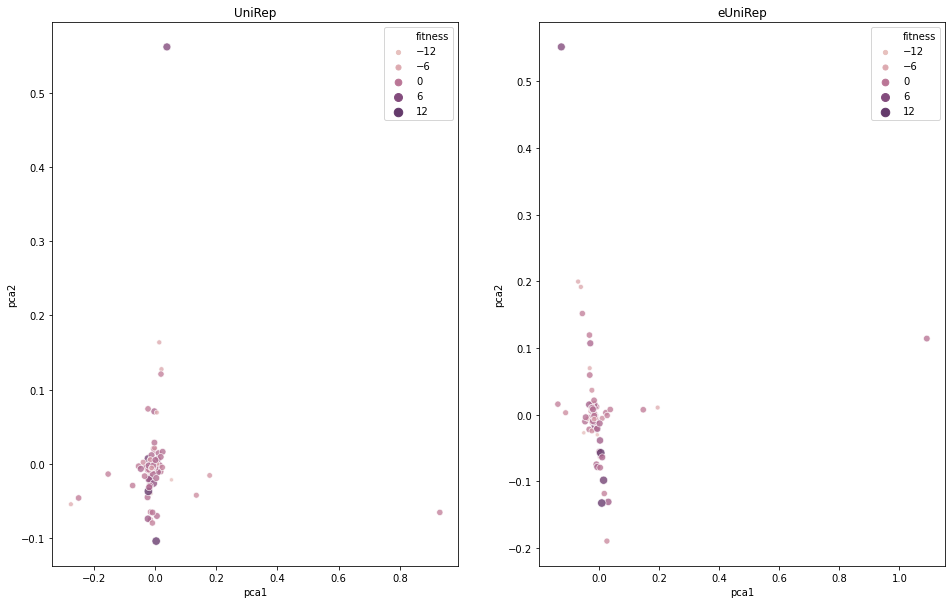

In [13]:
# plot PCA1 vs PCA2 for UniRep and eUniRep
plt.clf()
fig = plt.figure(figsize=(16,10))

ax1 = fig.add_subplot(1,2,1, title="UniRep")
sns.scatterplot(
    x="pca1", y="pca2",
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=unirep_df,
    legend="brief",
    ax=ax1,
    alpha=0.8 #this controls opacity
)

ax2 = fig.add_subplot(1,2,2, title="eUniRep")
sns.scatterplot(
    x="pca1", y="pca2",
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep_df,
    legend="brief",
    ax=ax2,
    alpha=0.8 #this controls opacity
)



<Figure size 432x288 with 0 Axes>

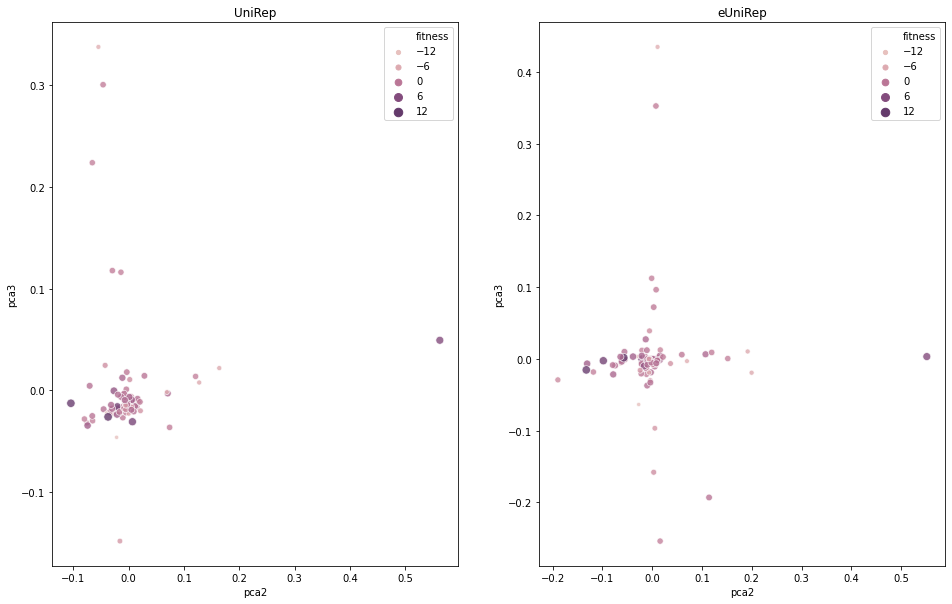

In [14]:
# plot PCA2 vs PCA3 for UniRep and eUniRep
plt.clf()
fig = plt.figure(figsize=(16,10))

ax1 = fig.add_subplot(1,2,1, title="UniRep")
sns.scatterplot(
    x="pca2", y="pca3",
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=unirep_df,
    legend="brief",
    ax=ax1,
    alpha=0.8 #this controls opacity
)

ax2 = fig.add_subplot(1,2,2, title="eUniRep")
sns.scatterplot(
    x="pca2", y="pca3",
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep_df,
    legend="brief",
    ax=ax2,
    alpha=0.8 #this controls opacity
)



<Figure size 432x288 with 0 Axes>

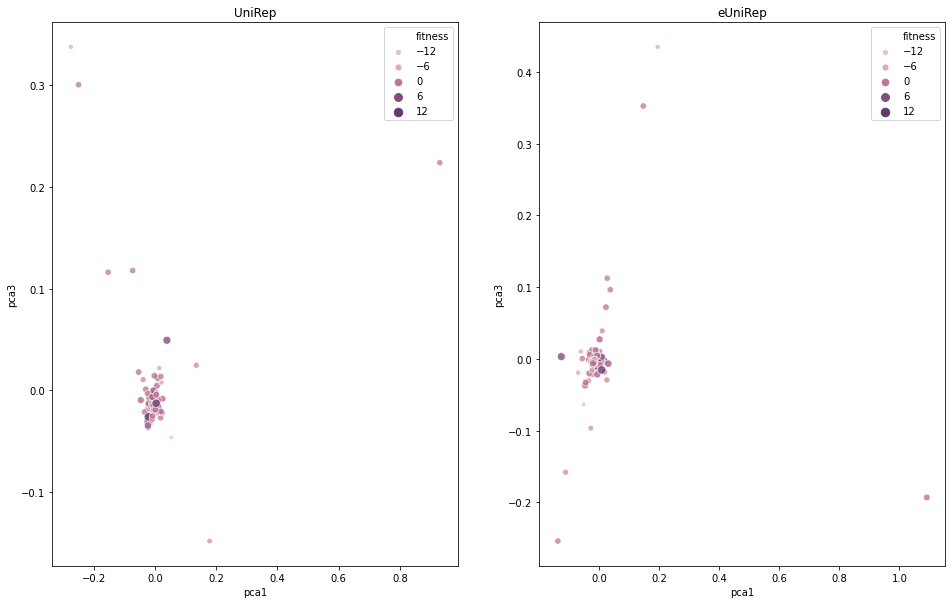

In [15]:
# plot PCA1 vs PCA3 for UniRep and eUniRep
plt.clf()
fig = plt.figure(figsize=(16,10))

ax1 = fig.add_subplot(1,2,1, title="UniRep")
sns.scatterplot(
    x="pca1", y="pca3",
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=unirep_df,
    legend="brief",
    ax=ax1,
    alpha=0.8 #this controls opacity
)

ax2 = fig.add_subplot(1,2,2, title="eUniRep")
sns.scatterplot(
    x="pca1", y="pca3",
    hue="fitness",
    size="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep_df,
    legend="brief",
    ax=ax2,
    alpha=0.8 #this controls opacity
)



In [40]:
# How many PCA's do we need to keep to get >90% variance kept?

# UNIREP:
pca_N = PCA(n_components=20)
pca_result_N = pca_N.fit_transform(unirep_df[feat_cols].values)
print('UniRep: Explained variation per principal component: {}'.format(np.sum(pca_N.explained_variance_ratio_)))

# eUNIREP:
epca_N = PCA(n_components=20)
epca_result_N = epca_N.fit_transform(eunirep_df[feat_cols].values)
print('UniRep: Explained variation per principal component: {}'.format(np.sum(epca_N.explained_variance_ratio_)))

# eUNIREP2:
epca2_N = PCA(n_components=20)
epca2_result_N = epca2_N.fit_transform(eunirep_df[feat_cols].values)
print('UniRep: Explained variation per principal component: {}'.format(np.sum(epca2_N.explained_variance_ratio_)))


UniRep: Explained variation per principal component: 0.9079596996307373
UniRep: Explained variation per principal component: 0.914459228515625
UniRep: Explained variation per principal component: 0.9144648909568787


In [41]:
# run TSNE with 2 components on the 20-component PCAs

# UNIREP:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result_N)

# add tsne results to dataframe
unirep_df['tsne-2d-1'] = tsne_results[:,0]
unirep_df['tsne-2d-2'] = tsne_results[:,1]

# EUNIREP:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(epca_result_N)

# add tsne results to dataframe
eunirep_df['tsne-2d-1'] = tsne_results[:,0]
eunirep_df['tsne-2d-2'] = tsne_results[:,1]

# EUNIREP:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(epca2_result_N)

# add tsne results to dataframe
eunirep2_df['tsne-2d-1'] = tsne_results[:,0]
eunirep2_df['tsne-2d-2'] = tsne_results[:,1]


[t-SNE] Computing 84 nearest neighbors...
[t-SNE] Indexed 85 samples in 0.000s...
[t-SNE] Computed neighbors for 85 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 85 / 85
[t-SNE] Mean sigma: 0.053272
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.493965
[t-SNE] KL divergence after 300 iterations: 0.749038
[t-SNE] Computing 84 nearest neighbors...
[t-SNE] Indexed 85 samples in 0.000s...
[t-SNE] Computed neighbors for 85 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 85 / 85
[t-SNE] Mean sigma: 0.063964
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.496433
[t-SNE] KL divergence after 300 iterations: 0.673935
[t-SNE] Computing 84 nearest neighbors...
[t-SNE] Indexed 85 samples in 0.000s...
[t-SNE] Computed neighbors for 85 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 85 / 85
[t-SNE] Mean sigma: 0.063984
[t-SNE] KL divergence after 250 iterations with early 

<Figure size 432x288 with 0 Axes>

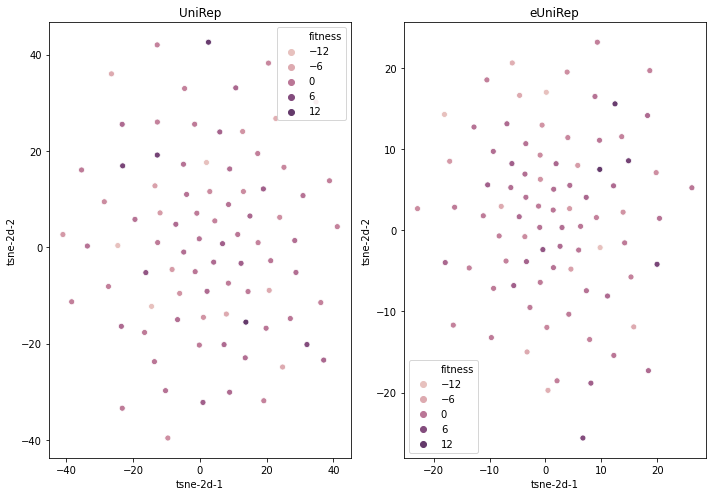

In [18]:
# plot t-SNE's:
plt.clf()
fig = plt.figure(figsize=(10,7))

ax1 = fig.add_subplot(1,2,1, title="UniRep")

sns.scatterplot(
    x="tsne-2d-1", y="tsne-2d-2",
    hue="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=unirep_df,
    legend="brief",
    ax=ax1,
    #alpha=0.3
)

ax2 = fig.add_subplot(1,2,2, title="eUniRep")

sns.scatterplot(
    x="tsne-2d-1", y="tsne-2d-2",
    hue="fitness",
    palette=sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True),
    data=eunirep_df,
    legend="brief",
    ax=ax2,
    #alpha=0.3
)


plt.tight_layout()
plt.show()

## Top Model Training & Performance Testing

In [0]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import RidgeCV

In [20]:
# turn ePCA_24 into a dataframe for use as X for top model training
pca_eX_df = pd.DataFrame(epca_result_N, columns = [ 'pca' + str(j) for j in range(1, epca_result_N.shape[1] + 1) ])
pca_eX_df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20
0,1.091369,0.114185,-0.193232,0.007036,-0.005113,-0.005623,0.007174,-0.008469,0.002863,0.000185,0.002106,0.001369,0.003047,-0.001679,-0.001294,0.002445,-0.000935,-0.000086,-0.000687,-0.000693
1,-0.028897,0.107078,0.006464,-0.031373,0.019083,0.015794,-0.084303,-0.034705,0.038125,-0.043311,-0.013934,0.039151,0.025555,0.058978,-0.019499,-0.002544,-0.014910,0.038875,0.014646,-0.005158
2,-0.007295,-0.006008,-0.001295,-0.019483,-0.017622,0.004462,-0.002410,0.004990,0.001946,-0.002583,-0.004111,0.002145,-0.003415,0.008280,-0.001138,-0.005580,-0.010024,0.004356,-0.003683,-0.005321
3,-0.060328,0.191705,0.010379,0.006039,-0.034883,0.008670,0.088128,-0.003491,-0.022836,0.023510,-0.044557,-0.009570,0.000275,0.035638,-0.003924,0.010227,0.016558,0.015335,0.013019,-0.003633
4,-0.017458,-0.014163,-0.003401,-0.003406,-0.032091,0.026777,-0.007248,0.004544,-0.011868,-0.019017,0.038855,-0.021364,0.002457,0.009028,-0.009986,0.006523,-0.004440,-0.008391,-0.004832,0.015087


UniRep alpha chosen: 0.38566204211634725
eUniRep alpha chosen: 0.7278953843983146
PCA_eUniRep alpha chosen: 62.10169418915616


<Figure size 432x288 with 0 Axes>

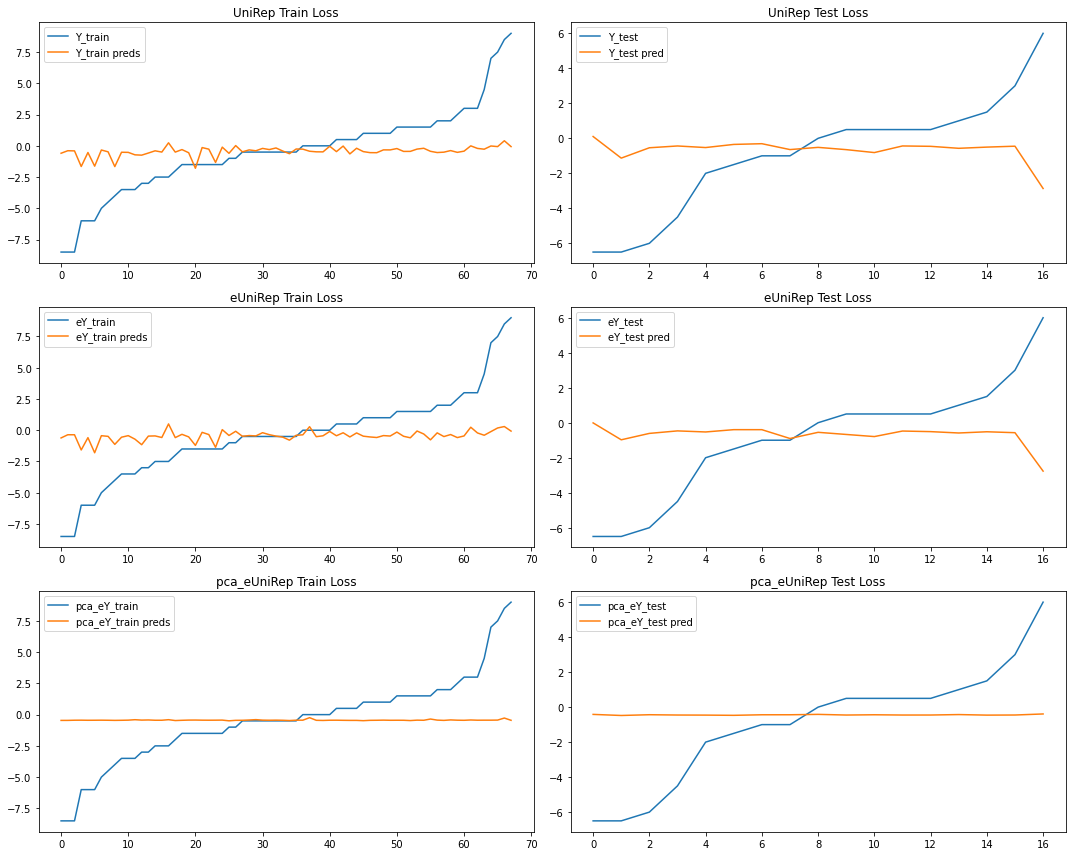

In [43]:
# randomly select subset of sequence as input data
np.random.seed(42)
rndperm = np.random.permutation(eunirep_df.shape[0])

# number of sequences per batch
BATCH_SIZE = 85

X = unirep_df.loc[rndperm[0:BATCH_SIZE], feat_cols]
eX = eunirep_df.loc[rndperm[0:BATCH_SIZE], feat_cols]
#pca_eX = pca_eX_df.loc[rndperm[0:BATCH_SIZE]] # UNCOMMENT THIS TO GET PCA PLOT BACK
pca_eX = eunirep2_df.loc[rndperm[0:BATCH_SIZE], feat_cols] # TEMPORARILY PUT EUNIREP2 (BLAC WEIGHTS) WHERE PCA SHOULD BE AS WAS TOO LAZY TO UPDATE PLOTTING.
Y = eunirep_df.loc[rndperm[0:BATCH_SIZE], "fitness"]

# train-test split for both 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
eX_train, eX_test, eY_train, eY_test = train_test_split(eX, Y, test_size=0.2, random_state=42)
pca_eX_train, pca_eX_test, pca_eY_train, pca_eY_test = train_test_split(pca_eX, Y, test_size=0.2, random_state=42)


# ridge regression model setup
kfold = KFold(n_splits=10, random_state=42, shuffle=True)

model = RidgeCV(alphas=np.logspace(-4,4,30), cv=kfold)
emodel = RidgeCV(alphas=np.logspace(-4,4,30), cv=kfold)
pca_emodel = RidgeCV(alphas=np.logspace(-4,4,30), cv=kfold)

# UNCOMMENT THIS TO SEE ALL THE ALPHAS TESTED
#ridge_params = model.get_params()
#print('alphas to test:', ridge_params['alphas'])

# fit the model
model.fit(X_train, Y_train)
print('UniRep alpha chosen:', str(model.alpha_))
emodel.fit(eX_train, eY_train)
print('eUniRep alpha chosen:', str(emodel.alpha_))
pca_emodel.fit(pca_eX_train, pca_eY_train)
print('PCA_eUniRep alpha chosen:', str(pca_emodel.alpha_))


# predict fitness to get train and test losses
Y_train_preds = model.predict(X_train)
Y_test_preds = model.predict(X_test)
eY_train_preds = emodel.predict(eX_train)
eY_test_preds = emodel.predict(eX_test)
pca_eY_train_preds = pca_emodel.predict(pca_eX_train)
pca_eY_test_preds = pca_emodel.predict(pca_eX_test)

train_loss = np.linalg.norm(Y_train_preds - Y_train)
test_loss = np.linalg.norm(Y_test_preds - Y_test)
etrain_loss = np.linalg.norm(eY_train_preds - eY_train)
etest_loss = np.linalg.norm(eY_test_preds - eY_test)
pca_etrain_loss = np.linalg.norm(pca_eY_train_preds - pca_eY_train)
pca_etest_loss = np.linalg.norm(pca_eY_test_preds - pca_eY_test)

# plot train and test losses
plt.clf()
fig = plt.figure(figsize=(15,12))

ax1 = fig.add_subplot(3,2,1, title="UniRep Train Loss")
ax1.plot(np.arange(len(Y_train)), np.array(Y_train)[np.argsort(Y_train)])
ax1.plot(np.arange(len(Y_train)), np.array(Y_train_preds)[np.argsort(Y_train)])
ax1.legend(['Y_train','Y_train preds'])

ax2 = fig.add_subplot(3,2,2, title="UniRep Test Loss")
ax2.plot(np.arange(len(Y_test)), np.array(Y_test)[np.argsort(Y_test)])
ax2.plot(np.arange(len(Y_test)), np.array(Y_test_preds)[np.argsort(Y_test)])
ax2.legend(['Y_test','Y_test pred'])

ax3 = fig.add_subplot(3,2,3, title="eUniRep Train Loss")
ax3.plot(np.arange(len(eY_train)), np.array(eY_train)[np.argsort(eY_train)])
ax3.plot(np.arange(len(eY_train)), np.array(eY_train_preds)[np.argsort(eY_train)])
ax3.legend(['eY_train','eY_train preds'])

ax4 = fig.add_subplot(3,2,4, title="eUniRep Test Loss")
ax4.plot(np.arange(len(eY_test)), np.array(eY_test)[np.argsort(eY_test)])
ax4.plot(np.arange(len(eY_test)), np.array(eY_test_preds)[np.argsort(eY_test)])
ax4.legend(['eY_test','eY_test pred'])

ax5 = fig.add_subplot(3,2,5, title="pca_eUniRep Train Loss")
ax5.plot(np.arange(len(pca_eY_train)), np.array(pca_eY_train)[np.argsort(pca_eY_train)])
ax5.plot(np.arange(len(pca_eY_train)), np.array(pca_eY_train_preds)[np.argsort(pca_eY_train)])
ax5.legend(['pca_eY_train','pca_eY_train preds'])

ax6 = fig.add_subplot(3,2,6, title="pca_eUniRep Test Loss")
ax6.plot(np.arange(len(pca_eY_test)), np.array(pca_eY_test)[np.argsort(pca_eY_test)])
ax6.plot(np.arange(len(pca_eY_test)), np.array(pca_eY_test_preds)[np.argsort(pca_eY_test)])
ax6.legend(['pca_eY_test','pca_eY_test pred'])

plt.tight_layout()
plt.show()


## Improvement over random sampling 
Test top model function in the same way as done in Supplementary Figure 2 of the Low-N engineering paper (but for TEM-1 instead of avGFP; and instead of training on Sarkisyan and testing on SynNeigh and FP Homologs, this trains and tests on random splits of Firnberg et al)

The purpose of doing this despite the clearly good fit function for Ridge Regression (see above) is for use as a comparision for datasets that may look less ideal (i.e. <96 training data points)

In [44]:
# number of batches to test
N_BATCH = 5

# number of sequences per training batch
TRAIN_BATCH_SIZE = 68

# number of sequences per training batch
HOLDOUT_BATCH_SIZE = 17

# number of random trials to perform for baseline
N_RAND_BATCHES = 10

# wild-type fitness
WT_FIT = 0

unirep_scores = []
eunirep_scores = []
pca_eunirep_scores = []
for i in range(N_BATCH):
  # change random seed for each batch
  np.random.seed(42*(i+2))
  rndperm = np.random.permutation(eunirep_df.shape[0])

  # data setup
  X = unirep_df.loc[rndperm[0:TRAIN_BATCH_SIZE], feat_cols]
  eX = eunirep_df.loc[rndperm[0:TRAIN_BATCH_SIZE], feat_cols]
  pca_eX = pca_eX_df.loc[rndperm[0:TRAIN_BATCH_SIZE]]
  Y = eunirep_df.loc[rndperm[0:TRAIN_BATCH_SIZE], "fitness"]

  X_holdout = unirep_df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], feat_cols]
  eX_holdout = eunirep_df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], feat_cols]
  pca_eX_holdout = pca_eX_df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE]]
  Y_holdout = eunirep_df.loc[rndperm[TRAIN_BATCH_SIZE:TRAIN_BATCH_SIZE+HOLDOUT_BATCH_SIZE], "fitness"]

  # ridge regression model setup
  kfold = KFold(n_splits=10, shuffle=True)

  model = RidgeCV(alphas=np.logspace(-4,4,20), cv=kfold)
  emodel = RidgeCV(alphas=np.logspace(-4,4,20), cv=kfold)
  pca_emodel = RidgeCV(alphas=np.logspace(-4,4,20), cv=kfold)

  # fit the model
  model.fit(X, Y)
  emodel.fit(eX, Y)
  pca_emodel.fit(pca_eX, Y)

  # use model to sort holdout set and get top TRAIN_BATCH_SIZE predicted fitness
  Y_preds = model.predict(X_holdout)
  eY_preds = emodel.predict(eX_holdout)
  pca_eY_preds = pca_emodel.predict(pca_eX_holdout)

  usorted = np.array(Y_holdout)[np.argsort(Y_preds)][::-1][:5] # NOTE: 5 IS USED HERE BECAUSE WE HAVE A TINY DATASET - NO ROOM FOR VALIDATION... :(
  esorted = np.array(Y_holdout)[np.argsort(eY_preds)][::-1][:5]
  pca_esorted = np.array(Y_holdout)[np.argsort(pca_eY_preds)][::-1][:5]

  # Note: wild-type fitness = WT_FIT (thats the scoring metric)
  usorted_count = np.sum([1 if i > WT_FIT else 0 for i in usorted])
  esorted_count = np.sum([1 if i > WT_FIT else 0 for i in esorted])
  pca_esorted_count = np.sum([1 if i > WT_FIT else 0 for i in pca_esorted])

  # randomly shuffle holdout set RAND_BATCHES time
  # and take average of top TRAIN_BATCH_SIZE fitness
  avg_rand_count = 0
  for j in range(N_RAND_BATCHES):
    np.random.seed(42*(i+2) + (1+j))
    rand_Y = np.random.permutation(np.array(Y_holdout))[:5] # SAME COMMMENT HERE
    avg_rand_count += np.sum([1 if i > 1 else 0 for i in rand_Y])
  avg_rand_count /= N_RAND_BATCHES

  # final score ratio:
  unirep_scores.append(usorted_count/avg_rand_count)
  eunirep_scores.append(esorted_count/avg_rand_count)
  pca_eunirep_scores.append(pca_esorted_count/avg_rand_count)

# note: random baseline = 1 (as these are ratios)
print("UniRep:", unirep_scores, "Mean Score:", np.mean(unirep_scores))
print("eUniRep:", eunirep_scores, "Mean Score:", np.mean(eunirep_scores))
print("PCA_eUniRep:", pca_eunirep_scores, "Mean Score:", np.mean(pca_eunirep_scores))

UniRep: [1.5789473684210527, 1.1111111111111112, 0.625, 1.1111111111111112, 0.5882352941176471] Mean Score: 1.0028809769521843
eUniRep: [1.0526315789473684, 0.0, 0.625, 3.333333333333333, 1.1764705882352942] Mean Score: 1.237487100103199
PCA_eUniRep: [1.0526315789473684, 0.0, 0.625, 3.333333333333333, 0.5882352941176471] Mean Score: 1.1198400412796696
